# Pre-Requisites

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install torch>=1.2.0
!pip install torchaudio

     |████████████████████████████████| 1.9 MB 5.2 MB/s 


### Libraries

In [ ]:
import torch
from torch.autograd import Variable
from torch.distributions import MultivariateNormal
from torch.nn import BCELoss, MSELoss

from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import matplotlib.pyplot as plt
import random
from torchvision import transforms

import numpy as np
import plotly.express as px
import math, os
import copy
from tqdm import tqdm

# The Model

## Build InfoVAE model

### Custom Layers

In [ ]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

### Testing Functions (Not Required)

In [ ]:
def get_flatten_output():
    model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 64, 4, 2),
        torch.nn.LeakyReLU(),
        torch.nn.Conv2d(64, 128, 4, 2),
        torch.nn.LeakyReLU(),
        Flatten(),
    )
    return model(Variable(torch.rand(2,1,28,28))).size()
get_flatten_output()

torch.Size([2, 3200])

In [ ]:
def get_reshape_output():
    model = torch.nn.Sequential(
        torch.nn.Linear(2, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 7*7*128),
        torch.nn.ReLU(),
        Reshape((128,7,7,)),
        torch.nn.ConvTranspose2d(128, 64, 4, 2),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(64, 1, 4, 2, padding=3),
        torch.nn.Sigmoid()
    )
    return model(Variable(torch.rand(2,2))).size()
get_reshape_output()

torch.Size([2, 1, 28, 28])

### Define Models (Encoder & Decoder)

In [ ]:
# Encoder and decoder use the DC-GAN architecture
class Encoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, stride=2, padding=1),              # Input Shape: 128x1284x8     Output Shape: 64x64x16
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=4, stride=2, padding=1),              # Input Shape: 64x64x16       Output Shape: 32x32x16
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 32, 4, 2, padding=1),                                                         # Input Shape: 32x32x16       Output Shape: 16x16x32
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 16, 4, 2, padding=1),                                                         # Input Shape: 16x16x32       Output Shape: 8x8x16
            torch.nn.LeakyReLU(),
            Flatten(),                                                                                        # Input Shape: 8x8x16         Output Shape: 1024 (1-dim)
            torch.nn.Linear(in_features=1024, out_features=512),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(512, z_dim)
        ])
        
    def forward(self, x):
        #print("Encoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x
    
    
class Decoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Linear(z_dim, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            Reshape((16,8,8,)),                                                                                         # Output Shape: 8x8x16
            torch.nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),              # Input Shape: 8x8x4        Output Shape: 16x16x8
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 16, 4, 2, padding=1),                                                          # Input Shape: 16x16x8      Output Shape: 32x32x16
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 16, 4, 2, padding=1),                                                          # Input Shape: 32x32x16     Output Shape: 64x64x16
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 8, 4, 2, padding=1),                                                           # Input Shape: 64x64x16     Output Shape: 128x128x8
            torch.nn.Sigmoid()
        ])
        
    def forward(self, x):
        #print("Decoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x
    

### Define MMD Loss Functions

In [ ]:
# Based on https://github.com/ShengjiaZhao/MMD-Variational-Autoencoder/blob/master/mmd_vae.ipynb

def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

### Define Model Class

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, z_dim):
        super(Model, self).__init__()
        self.latent_dim = z_dim
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        self.centre_0 = -1.0
        self.centre_1 = 1.0
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

    def predict(self, x):
        pdist = torch.nn.PairwiseDistance(p=2)
        z = self.encoder(x).cpu()
        pred = torch.argmin(torch.hstack([pdist(z, torch.zeros(self.latent_dim).fill_(self.centre_0)).unsqueeze(1), 
                                          pdist(z, torch.zeros(self.latent_dim).fill_(self.centre_1)).unsqueeze(1)]),
                            dim=1)
        return pred

In [ ]:
# Testing function (passing z_dim)4/1AX4XfWgGDO3v5tn4Wt2IVfTAV_p1ISw4YUwRJ2ns_030a3ZLUoZ9joTZ7Eo
model_test = Model(2)
model_test.centre_0 = -1.0
model_test.centre_1 = 1.0

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Trainable parameters: ", count_parameters(model_test))

Trainable parameters:  1097882


In [ ]:
# Testing functions
z, x_reconstructed = model_test(Variable(torch.rand(1,8,128,128)))
z.size(), x_reconstructed.size()

(torch.Size([1, 2]), torch.Size([1, 8, 128, 128]))

In [ ]:
#Testing functions
pred = model_test.predict(Variable(torch.rand(200,8,128,128)))
pred.size()

torch.Size([200])

In [ ]:
del(model_test)

In [ ]:
def model_saver(model_state, optimizer_state, path):
  torch.save({'model_state_dict': model_state,
              'optimizer_state_dict': optimizer_state,
              }, path)

## Build Supervised_VAE Trainer

#### Trainer

In [ ]:
reconstruction_loss = MSELoss(reduction='mean')
#reconstruction_loss = BCELoss(reduction='mean')

In [ ]:
def get_losses(model, images, labels, alpha, beta, m_0, m_1, use_cuda=True, eval_mode=False):
  x = Variable(images, requires_grad=False)
  if use_cuda:
    x = x.cuda()

  z, x_reconstructed = model(x)

  one_labels = torch.nonzero(labels).squeeze()
  zero_labels = torch.nonzero(1-labels).squeeze()
  z_one = z[one_labels]
  z_zero = z[zero_labels]

  mmd_mod = []
  if z_zero.size()[0]>0:
    if len(list(z_zero.size()))<2:
      z_zero =z_zero.unsqueeze(0)
    true_samples_zero = Variable(torch.stack([m_0.sample() for _ in range(z_zero.size()[0])]), requires_grad=False)
    if use_cuda:
      true_samples_zero = true_samples_zero.cuda()
    mmd_mod.append(compute_mmd(true_samples_zero, z_zero))

  if z_one.size()[0]>0:
    if len(list(z_one.size()))<2:
      z_one = z_one.unsqueeze(0)
    true_samples_one = Variable(torch.stack([m_1.sample() for _ in range(z_one.size()[0])]), requires_grad=False)
    if use_cuda:
      true_samples_one = true_samples_one.cuda()
    mmd_mod.append(compute_mmd(true_samples_one, z_one))

  mmd = beta*((mmd_mod[0]+mmd_mod[1]) if len(mmd_mod)==2 else mmd_mod[0])
  #nll = alpha*((x_reconstructed - x).pow(2).mean())
  nll = alpha*(reconstruction_loss(x_reconstructed, x))

  if eval_mode:
    preds = model.predict(x)
    return nll, mmd, preds
  else:
    return nll, mmd

In [ ]:
# TODO: Save z_dim in pt file.
centre_0 = -1.0
centre_1 = 1.0

def get_model(z_dim, lr, use_cuda=True, chkpt_path=None):
  model = Model(z_dim)
  model.centre_0 = centre_0
  model.centre_1 = centre_1
  if use_cuda:
    model = model.cuda()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  if chkpt_path:
    print("Loading model from checkpoint "+chkpt_path+" ....")
    checkpoint = torch.load(chkpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("Done!")

  return model, optimizer

In [ ]:
def train(train_data, val_data, z_dim=2, n_epochs=10, alpha=1.0, beta=1.0, lr=0.001, use_cuda=True, batch_size=200, save_every=100, save_path=None, chkpt_path=None):
  
  m_0 = MultivariateNormal(torch.zeros(z_dim).fill_(centre_0), torch.zeros(z_dim, z_dim).fill_diagonal_(0.15))        # Cluster center for 0 datapoints is at (-2,-2,-2...)
  m_1 = MultivariateNormal(torch.zeros(z_dim).fill_(centre_1), torch.zeros(z_dim, z_dim).fill_diagonal_(0.15))         # Cluster center for 1 datapoints is at (2, 2, 2...)
    
  model, optimizer = get_model(z_dim, lr, use_cuda, chkpt_path)
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_opt_state = copy.deepcopy(optimizer.state_dict())
  
  best_epoch, best_acc = 0, 0.0
  for epoch in range(n_epochs):
    print('\nEpoch {}/{}'.format(epoch, n_epochs - 1))
    print('-' * 10)
    
    # Training Phase
    model.train()
    rec_loss, mmd_loss = [], []
    for images, labels in tqdm(train_data):
      optimizer.zero_grad()

      nll, mmd = get_losses(model=model, 
                            images=images, 
                            labels=labels,
                            alpha=alpha, beta=beta, 
                            m_0=m_0, m_1=m_1, 
                            use_cuda=use_cuda)

      loss = nll + mmd

      loss.backward()
      optimizer.step()

      rec_loss.append(nll.item())
      mmd_loss.append(mmd.item())

    print("Training Phase: NLL_Loss: {:.5f}, MMD_Loss: {:.5f}".format(
        (sum(rec_loss)/len(rec_loss)),
        (sum(mmd_loss)/len(mmd_loss))
    ))

    # Validation Phase
    model.eval()
    rec_loss, mmd_loss, label_list, pred_list = [], [], [], []
    for images, labels in tqdm(val_data):
      nll, mmd, preds = get_losses(model=model, 
                                   images=images, 
                                   labels=labels, 
                                   alpha=alpha, beta=beta,
                                   m_0=m_0, m_1=m_1, 
                                   use_cuda=use_cuda, eval_mode=True)

      rec_loss.append(nll.item())
      mmd_loss.append(mmd.item())

      label_list.append(labels.cpu().numpy())
      pred_list.append(preds.cpu().numpy())

    label = np.concatenate(label_list)
    preds = np.concatenate(pred_list)
    epoch_rec_loss = (sum(rec_loss)/len(rec_loss))
    epoch_mmd_loss = (sum(mmd_loss)/len(mmd_loss))
    epoch_acc = np.sum(preds==label)/label.shape[0]
    print("Validation Phase: NLL_Loss: {:.5f}, MMD_Loss: {:.5f}; Acc: {:.5f}; Corrects: {} of {}".format(
        epoch_rec_loss,
        epoch_mmd_loss,
        epoch_acc,
        np.sum(preds==label),
        label.shape[0]
    ))

    if epoch_acc > best_acc:
      best_epoch = epoch
      best_acc = epoch_acc
      best_model_wts = copy.deepcopy(model.state_dict())
      best_opt_state = copy.deepcopy(optimizer.state_dict())

    if save_path and ((epoch+1)%save_every == 0):
      print("\nSaving best weights found so far... ", end='')
      model_saver(best_model_wts, best_opt_state, save_path)
      print("Done!")
                
  print('\n\nAt Epoch {}: Best val Acc: {:4f}'.format(best_epoch, best_acc))
  model.load_state_dict(best_model_wts)
  return model

# The Data

## Define PyTorch Sound Dataset Builder Class

In [ ]:
class SoundDatasetBuilder(Dataset):
  def __init__(self, annotations_file, audio_dir, transform, target_sample_rate):
    self.annotations = pd.read_csv(annotations_file)
    self.audio_dir = audio_dir
    self.transform = transform
    self.target_sr = target_sample_rate

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    audio_sample_path = self._get_audio_sample_path(index)
    label = self._get_audio_sample_label(index)
    signal, sr = torchaudio.load(audio_sample_path)
    signal = self._resample_if_necessary(signal, sr)
    #signal = self._get_2_seconds(signal, self.target_sr, index)
    signal = self.transform(signal)
    #signal = self._minMaxScaler(signal)
    return signal, label

  def _get_2_seconds(self, signal, sr, index):
    frames_in_2s = 2*sr                                                         # Number of frames in 2 seconds
    start_position = int(self.annotations['start'].iloc[index])*sr              # Get starting point for each signal
    signal_2s = signal[..., start_position:start_position+frames_in_2s]
    return signal_2s
  
  def _resample_if_necessary(self, signal, sr):
    if sr != self.target_sr:
      resampler = torchaudio.transforms.Resample(sr, self.target_sr)
      signal = resampler(signal)
    return signal

  def _minMaxScaler(self, signal, min=0.0, max=1.0):
    norm_signal = (signal - torch.min(signal)) / (torch.max(signal) - torch.min(signal))
    norm_signal = norm_signal*(max-min) + min
    return norm_signal

  def _get_audio_sample_path(self, index):
    path = os.path.join(self.audio_dir, self.annotations['filename'].iloc[index])
    return path

  def _get_audio_sample_label(self, index):
    return self.annotations['label'].iloc[index]

## Build Train and Val sets

In [ ]:
SAMPLE_RATE = 16000
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=1251,
        n_mels=128
    )

TRAIN_ANNOTATIONS_FILE = "/content/drive/MyDrive/valve_wav/valve_data/train.csv"
TRAIN_AUDIO_DIR = "/content/drive/MyDrive/valve_wav/valve_data/train"
train_data = SoundDatasetBuilder(TRAIN_ANNOTATIONS_FILE, TRAIN_AUDIO_DIR, mel_spectrogram, SAMPLE_RATE)

VAL_ANNOTATIONS_FILE = "/content/drive/MyDrive/valve_wav/valve_data/val.csv"
VAL_AUDIO_DIR = "/content/drive/MyDrive/valve_wav/valve_data/test"
val_data = SoundDatasetBuilder(VAL_ANNOTATIONS_FILE, VAL_AUDIO_DIR, mel_spectrogram, SAMPLE_RATE)

print(f"There are {len(train_data)} samples in the training dataset.")
print(f"There are {len(val_data)} samples in the validation dataset.")

There are 1918 samples in the training dataset.
There are 240 samples in the validation dataset.


# Train

## Define DataLoaders

In [ ]:
batch_size = 30               # Use 36, or 60    (Values that aren't perfect divisors of 9540 may cause training error) [Don't use small batch sizes]
val_batch_size = 20

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size, shuffle=True, num_workers=2,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=val_batch_size, shuffle=True, num_workers=2,
    pin_memory=True
)

In [ ]:
MODEL_NAME = 'vae_128_valve_e60_a1b1p5.pt'

In [ ]:
z_dim = 3
model = train(train_data = train_loader, 
              val_data = val_loader,
              z_dim=z_dim, 
              batch_size=batch_size,
              n_epochs=60,
              alpha=1.0,
              beta=1.5,
              save_every=10,
              save_path='/content/drive/MyDrive/valve_wav/VAE_Models/'+MODEL_NAME)
              #chkpt_path='/content/drive/MyDrive/slider_data/VAE_Models/vae_small_slider_e60_a1b1p5.pt')       # Mention a a checkpoiny path to do transfer learning from a checkpoint (previously trained model)


Epoch 0/59
----------


100%|██████████| 64/64 [01:37<00:00,  1.52s/it]


Training Phase: NLL_Loss: 0.41187, MMD_Loss: 1.28271


100%|██████████| 12/12 [00:52<00:00,  4.40s/it]


Validation Phase: NLL_Loss: 0.29354, MMD_Loss: 1.08474; Acc: 0.56667; Corrects: 136 of 240

Epoch 1/59
----------


100%|██████████| 64/64 [01:14<00:00,  1.17s/it]


Training Phase: NLL_Loss: 0.35997, MMD_Loss: 0.71375


100%|██████████| 12/12 [00:16<00:00,  1.34s/it]


Validation Phase: NLL_Loss: 0.29636, MMD_Loss: 0.52425; Acc: 0.75000; Corrects: 180 of 240

Epoch 2/59
----------


100%|██████████| 64/64 [01:10<00:00,  1.10s/it]


Training Phase: NLL_Loss: 0.35883, MMD_Loss: 0.31302


100%|██████████| 12/12 [00:15<00:00,  1.33s/it]


Validation Phase: NLL_Loss: 0.29395, MMD_Loss: 0.25838; Acc: 0.88750; Corrects: 213 of 240

Epoch 3/59
----------


100%|██████████| 64/64 [01:08<00:00,  1.07s/it]


Training Phase: NLL_Loss: 0.35602, MMD_Loss: 0.11578


100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


Validation Phase: NLL_Loss: 0.29209, MMD_Loss: 0.19419; Acc: 0.90833; Corrects: 218 of 240

Epoch 4/59
----------


100%|██████████| 64/64 [01:10<00:00,  1.10s/it]


Training Phase: NLL_Loss: 0.35485, MMD_Loss: 0.10183


100%|██████████| 12/12 [00:13<00:00,  1.10s/it]


Validation Phase: NLL_Loss: 0.29161, MMD_Loss: 0.10771; Acc: 0.93333; Corrects: 224 of 240

Epoch 5/59
----------


100%|██████████| 64/64 [01:10<00:00,  1.10s/it]


Training Phase: NLL_Loss: 0.35427, MMD_Loss: 0.07335


100%|██████████| 12/12 [00:12<00:00,  1.04s/it]


Validation Phase: NLL_Loss: 0.29102, MMD_Loss: 0.08261; Acc: 0.95417; Corrects: 229 of 240

Epoch 6/59
----------


100%|██████████| 64/64 [01:08<00:00,  1.08s/it]


Training Phase: NLL_Loss: 0.35393, MMD_Loss: 0.06031


100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


Validation Phase: NLL_Loss: 0.29077, MMD_Loss: 0.12464; Acc: 0.95417; Corrects: 229 of 240

Epoch 7/59
----------


100%|██████████| 64/64 [01:08<00:00,  1.07s/it]


Training Phase: NLL_Loss: 0.35395, MMD_Loss: 0.06559


100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


Validation Phase: NLL_Loss: 0.29059, MMD_Loss: 0.06387; Acc: 0.96250; Corrects: 231 of 240

Epoch 8/59
----------


100%|██████████| 64/64 [01:09<00:00,  1.09s/it]


Training Phase: NLL_Loss: 0.35352, MMD_Loss: 0.05860


100%|██████████| 12/12 [00:10<00:00,  1.16it/s]


Validation Phase: NLL_Loss: 0.29085, MMD_Loss: 0.07054; Acc: 0.96667; Corrects: 232 of 240

Epoch 9/59
----------


100%|██████████| 64/64 [01:06<00:00,  1.04s/it]


Training Phase: NLL_Loss: 0.35383, MMD_Loss: 0.06061


100%|██████████| 12/12 [00:13<00:00,  1.13s/it]


Validation Phase: NLL_Loss: 0.29083, MMD_Loss: 0.08226; Acc: 0.97083; Corrects: 233 of 240

Saving best weights found so far... Done!

Epoch 10/59
----------


100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


Training Phase: NLL_Loss: 0.35365, MMD_Loss: 0.05433


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Validation Phase: NLL_Loss: 0.29047, MMD_Loss: 0.11047; Acc: 0.97500; Corrects: 234 of 240

Epoch 11/59
----------


100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Training Phase: NLL_Loss: 0.35354, MMD_Loss: 0.05896


100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


Validation Phase: NLL_Loss: 0.29054, MMD_Loss: 0.07143; Acc: 0.95833; Corrects: 230 of 240

Epoch 12/59
----------


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Training Phase: NLL_Loss: 0.35339, MMD_Loss: 0.04760


100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Validation Phase: NLL_Loss: 0.29044, MMD_Loss: 0.09672; Acc: 0.96250; Corrects: 231 of 240

Epoch 13/59
----------


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Training Phase: NLL_Loss: 0.35339, MMD_Loss: 0.05072


100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Validation Phase: NLL_Loss: 0.29022, MMD_Loss: 0.05795; Acc: 0.97917; Corrects: 235 of 240

Epoch 14/59
----------


100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Training Phase: NLL_Loss: 0.35325, MMD_Loss: 0.05058


100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


Validation Phase: NLL_Loss: 0.29034, MMD_Loss: 0.09695; Acc: 0.97917; Corrects: 235 of 240

Epoch 15/59
----------


100%|██████████| 64/64 [00:59<00:00,  1.07it/s]


Training Phase: NLL_Loss: 0.35332, MMD_Loss: 0.04309


100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Validation Phase: NLL_Loss: 0.28993, MMD_Loss: 0.05873; Acc: 0.98750; Corrects: 237 of 240

Epoch 16/59
----------


100%|██████████| 64/64 [00:58<00:00,  1.09it/s]


Training Phase: NLL_Loss: 0.35314, MMD_Loss: 0.04939


100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Validation Phase: NLL_Loss: 0.29052, MMD_Loss: 0.10101; Acc: 0.97500; Corrects: 234 of 240

Epoch 17/59
----------


100%|██████████| 64/64 [00:58<00:00,  1.10it/s]


Training Phase: NLL_Loss: 0.35287, MMD_Loss: 0.05137


100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Validation Phase: NLL_Loss: 0.28969, MMD_Loss: 0.04461; Acc: 0.98333; Corrects: 236 of 240

Epoch 18/59
----------


100%|██████████| 64/64 [00:57<00:00,  1.12it/s]


Training Phase: NLL_Loss: 0.35292, MMD_Loss: 0.04601


100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Validation Phase: NLL_Loss: 0.28990, MMD_Loss: 0.07693; Acc: 0.97500; Corrects: 234 of 240

Epoch 19/59
----------


100%|██████████| 64/64 [00:56<00:00,  1.13it/s]


Training Phase: NLL_Loss: 0.35290, MMD_Loss: 0.05217


100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Validation Phase: NLL_Loss: 0.29034, MMD_Loss: 0.06685; Acc: 0.98333; Corrects: 236 of 240

Saving best weights found so far... Done!

Epoch 20/59
----------


100%|██████████| 64/64 [00:56<00:00,  1.14it/s]


Training Phase: NLL_Loss: 0.35267, MMD_Loss: 0.04699


100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


Validation Phase: NLL_Loss: 0.28971, MMD_Loss: 0.07806; Acc: 0.97917; Corrects: 235 of 240

Epoch 21/59
----------


100%|██████████| 64/64 [00:55<00:00,  1.15it/s]


Training Phase: NLL_Loss: 0.35252, MMD_Loss: 0.04459


100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Validation Phase: NLL_Loss: 0.28902, MMD_Loss: 0.05750; Acc: 0.97917; Corrects: 235 of 240

Epoch 22/59
----------


100%|██████████| 64/64 [00:55<00:00,  1.15it/s]


Training Phase: NLL_Loss: 0.35214, MMD_Loss: 0.04534


100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Validation Phase: NLL_Loss: 0.28989, MMD_Loss: 0.05379; Acc: 0.97917; Corrects: 235 of 240

Epoch 23/59
----------


100%|██████████| 64/64 [00:54<00:00,  1.17it/s]


Training Phase: NLL_Loss: 0.35200, MMD_Loss: 0.04244


100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Validation Phase: NLL_Loss: 0.28878, MMD_Loss: 0.05526; Acc: 0.98333; Corrects: 236 of 240

Epoch 24/59
----------


100%|██████████| 64/64 [00:54<00:00,  1.16it/s]


Training Phase: NLL_Loss: 0.35166, MMD_Loss: 0.04164


100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Validation Phase: NLL_Loss: 0.28883, MMD_Loss: 0.05676; Acc: 0.98333; Corrects: 236 of 240

Epoch 25/59
----------


100%|██████████| 64/64 [00:54<00:00,  1.18it/s]


Training Phase: NLL_Loss: 0.35149, MMD_Loss: 0.04072


100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Validation Phase: NLL_Loss: 0.28829, MMD_Loss: 0.07023; Acc: 0.97917; Corrects: 235 of 240

Epoch 26/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.19it/s]


Training Phase: NLL_Loss: 0.35105, MMD_Loss: 0.04276


100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Validation Phase: NLL_Loss: 0.28785, MMD_Loss: 0.05760; Acc: 0.98750; Corrects: 237 of 240

Epoch 27/59
----------


100%|██████████| 64/64 [00:54<00:00,  1.18it/s]


Training Phase: NLL_Loss: 0.35093, MMD_Loss: 0.04205


100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Validation Phase: NLL_Loss: 0.28764, MMD_Loss: 0.08433; Acc: 0.97917; Corrects: 235 of 240

Epoch 28/59
----------


100%|██████████| 64/64 [00:54<00:00,  1.18it/s]


Training Phase: NLL_Loss: 0.35000, MMD_Loss: 0.04203


100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Validation Phase: NLL_Loss: 0.28709, MMD_Loss: 0.05992; Acc: 0.99167; Corrects: 238 of 240

Epoch 29/59
----------


100%|██████████| 64/64 [00:54<00:00,  1.18it/s]


Training Phase: NLL_Loss: 0.35011, MMD_Loss: 0.03941


100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


Validation Phase: NLL_Loss: 0.28655, MMD_Loss: 0.09530; Acc: 0.98750; Corrects: 237 of 240

Saving best weights found so far... Done!

Epoch 30/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.19it/s]


Training Phase: NLL_Loss: 0.34879, MMD_Loss: 0.04300


100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


Validation Phase: NLL_Loss: 0.28549, MMD_Loss: 0.06154; Acc: 0.98333; Corrects: 236 of 240

Epoch 31/59
----------


100%|██████████| 64/64 [00:55<00:00,  1.16it/s]


Training Phase: NLL_Loss: 0.34728, MMD_Loss: 0.03754


100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Validation Phase: NLL_Loss: 0.28215, MMD_Loss: 0.04364; Acc: 0.99167; Corrects: 238 of 240

Epoch 32/59
----------


100%|██████████| 64/64 [00:54<00:00,  1.18it/s]


Training Phase: NLL_Loss: 0.34319, MMD_Loss: 0.04096


100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Validation Phase: NLL_Loss: 0.27896, MMD_Loss: 0.05948; Acc: 0.99167; Corrects: 238 of 240

Epoch 33/59
----------


100%|██████████| 64/64 [00:54<00:00,  1.18it/s]


Training Phase: NLL_Loss: 0.34119, MMD_Loss: 0.03248


100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Validation Phase: NLL_Loss: 0.27789, MMD_Loss: 0.04545; Acc: 0.99167; Corrects: 238 of 240

Epoch 34/59
----------


100%|██████████| 64/64 [00:54<00:00,  1.18it/s]


Training Phase: NLL_Loss: 0.34084, MMD_Loss: 0.03938


100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Validation Phase: NLL_Loss: 0.27746, MMD_Loss: 0.05088; Acc: 0.99167; Corrects: 238 of 240

Epoch 35/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.19it/s]


Training Phase: NLL_Loss: 0.34016, MMD_Loss: 0.04305


100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Validation Phase: NLL_Loss: 0.27720, MMD_Loss: 0.07383; Acc: 0.98333; Corrects: 236 of 240

Epoch 36/59
----------


100%|██████████| 64/64 [00:54<00:00,  1.18it/s]


Training Phase: NLL_Loss: 0.33949, MMD_Loss: 0.04349


100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Validation Phase: NLL_Loss: 0.27775, MMD_Loss: 0.05455; Acc: 0.98333; Corrects: 236 of 240

Epoch 37/59
----------


100%|██████████| 64/64 [00:54<00:00,  1.18it/s]


Training Phase: NLL_Loss: 0.34003, MMD_Loss: 0.04515


100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Validation Phase: NLL_Loss: 0.27603, MMD_Loss: 0.06212; Acc: 0.97917; Corrects: 235 of 240

Epoch 38/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.19it/s]


Training Phase: NLL_Loss: 0.34009, MMD_Loss: 0.04223


100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Validation Phase: NLL_Loss: 0.28129, MMD_Loss: 0.06197; Acc: 0.99167; Corrects: 238 of 240

Epoch 39/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.20it/s]


Training Phase: NLL_Loss: 0.33940, MMD_Loss: 0.03864


100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Validation Phase: NLL_Loss: 0.27686, MMD_Loss: 0.07785; Acc: 0.98333; Corrects: 236 of 240

Saving best weights found so far... Done!

Epoch 40/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.19it/s]


Training Phase: NLL_Loss: 0.33930, MMD_Loss: 0.04724


100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Validation Phase: NLL_Loss: 0.27850, MMD_Loss: 0.04547; Acc: 0.98333; Corrects: 236 of 240

Epoch 41/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.19it/s]


Training Phase: NLL_Loss: 0.33887, MMD_Loss: 0.03690


100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Validation Phase: NLL_Loss: 0.27620, MMD_Loss: 0.06139; Acc: 0.98333; Corrects: 236 of 240

Epoch 42/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.19it/s]


Training Phase: NLL_Loss: 0.33774, MMD_Loss: 0.03808


100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Validation Phase: NLL_Loss: 0.27573, MMD_Loss: 0.05718; Acc: 0.99167; Corrects: 238 of 240

Epoch 43/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.20it/s]


Training Phase: NLL_Loss: 0.33769, MMD_Loss: 0.03890


100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Validation Phase: NLL_Loss: 0.27561, MMD_Loss: 0.05204; Acc: 0.98750; Corrects: 237 of 240

Epoch 44/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.20it/s]


Training Phase: NLL_Loss: 0.33706, MMD_Loss: 0.04203


100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Validation Phase: NLL_Loss: 0.27488, MMD_Loss: 0.06026; Acc: 0.99167; Corrects: 238 of 240

Epoch 45/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.20it/s]


Training Phase: NLL_Loss: 0.33678, MMD_Loss: 0.03905


100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Validation Phase: NLL_Loss: 0.27657, MMD_Loss: 0.06550; Acc: 0.99583; Corrects: 239 of 240

Epoch 46/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.20it/s]


Training Phase: NLL_Loss: 0.33683, MMD_Loss: 0.03726


100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Validation Phase: NLL_Loss: 0.27527, MMD_Loss: 0.05289; Acc: 0.99167; Corrects: 238 of 240

Epoch 47/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.20it/s]


Training Phase: NLL_Loss: 0.33739, MMD_Loss: 0.03291


100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Validation Phase: NLL_Loss: 0.27528, MMD_Loss: 0.06392; Acc: 0.99583; Corrects: 239 of 240

Epoch 48/59
----------


100%|██████████| 64/64 [00:52<00:00,  1.21it/s]


Training Phase: NLL_Loss: 0.33840, MMD_Loss: 0.04312


100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Validation Phase: NLL_Loss: 0.27529, MMD_Loss: 0.05135; Acc: 0.99167; Corrects: 238 of 240

Epoch 49/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.20it/s]


Training Phase: NLL_Loss: 0.33676, MMD_Loss: 0.03562


100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Validation Phase: NLL_Loss: 0.27494, MMD_Loss: 0.08562; Acc: 0.99167; Corrects: 238 of 240

Saving best weights found so far... Done!

Epoch 50/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.20it/s]


Training Phase: NLL_Loss: 0.33708, MMD_Loss: 0.03708


100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Validation Phase: NLL_Loss: 0.27510, MMD_Loss: 0.04546; Acc: 0.99167; Corrects: 238 of 240

Epoch 51/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.19it/s]


Training Phase: NLL_Loss: 0.33610, MMD_Loss: 0.03563


100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Validation Phase: NLL_Loss: 0.27445, MMD_Loss: 0.07464; Acc: 0.98333; Corrects: 236 of 240

Epoch 52/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.19it/s]


Training Phase: NLL_Loss: 0.33581, MMD_Loss: 0.04037


100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Validation Phase: NLL_Loss: 0.27465, MMD_Loss: 0.05984; Acc: 0.99167; Corrects: 238 of 240

Epoch 53/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.19it/s]


Training Phase: NLL_Loss: 0.33656, MMD_Loss: 0.04509


100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Validation Phase: NLL_Loss: 0.27475, MMD_Loss: 0.06100; Acc: 0.99167; Corrects: 238 of 240

Epoch 54/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.20it/s]


Training Phase: NLL_Loss: 0.33579, MMD_Loss: 0.04269


100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Validation Phase: NLL_Loss: 0.27456, MMD_Loss: 0.06406; Acc: 0.98750; Corrects: 237 of 240

Epoch 55/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.19it/s]


Training Phase: NLL_Loss: 0.33520, MMD_Loss: 0.03650


100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Validation Phase: NLL_Loss: 0.27531, MMD_Loss: 0.07458; Acc: 0.98750; Corrects: 237 of 240

Epoch 56/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.19it/s]


Training Phase: NLL_Loss: 0.33559, MMD_Loss: 0.03981


100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Validation Phase: NLL_Loss: 0.27392, MMD_Loss: 0.04744; Acc: 0.99167; Corrects: 238 of 240

Epoch 57/59
----------


100%|██████████| 64/64 [00:54<00:00,  1.18it/s]


Training Phase: NLL_Loss: 0.33498, MMD_Loss: 0.03594


100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Validation Phase: NLL_Loss: 0.27359, MMD_Loss: 0.04750; Acc: 0.98750; Corrects: 237 of 240

Epoch 58/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.19it/s]


Training Phase: NLL_Loss: 0.33524, MMD_Loss: 0.03342


100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Validation Phase: NLL_Loss: 0.27328, MMD_Loss: 0.06170; Acc: 0.98750; Corrects: 237 of 240

Epoch 59/59
----------


100%|██████████| 64/64 [00:53<00:00,  1.19it/s]


Training Phase: NLL_Loss: 0.33517, MMD_Loss: 0.03466


100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Validation Phase: NLL_Loss: 0.27564, MMD_Loss: 0.04717; Acc: 0.98750; Corrects: 237 of 240

Saving best weights found so far... Done!


At Epoch 45: Best val Acc: 0.995833


# Load and Evaluate

**NOTE:** Run all cells in 'Build InfoVAE Model' section before attempting load.

In [ ]:
# Load model
model = Model(3)
checkpoint = torch.load('/content/drive/MyDrive/valve_wav/VAE_Models/vae_128_valve_e60_a1b1p5.pt') #, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
#model = torch.load('/content/drive/MyDrive/Pump_Data/Data_2secs/VAE_Models/vae_small_e60_a100.pth', map_location=torch.device('cpu'))

<All keys matched successfully>

In [ ]:
TEST_SET = 'test'
TEST_FOLDER = 'test' if TEST_SET in ['test', 'val'] else 'train'

### Direct classification of 2 seconds (No voting)

In [ ]:
val_batch_size = 15

In [ ]:
SAMPLE_RATE = 16000
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=1251,
        n_mels=128
    )

ANNOTATIONS_FILE = "/content/drive/MyDrive/valve_wav/valve_data/"+TEST_SET+".csv"
AUDIO_DIR = "/content/drive/MyDrive/valve_wav/valve_data/"+TEST_FOLDER
data = SoundDatasetBuilder(ANNOTATIONS_FILE, AUDIO_DIR, mel_spectrogram, SAMPLE_RATE)

data_loader = torch.utils.data.DataLoader(data,
                                          batch_size=val_batch_size, 
                                          shuffle=False, num_workers=2,
                                          pin_memory=True)


print(f"There are {len(data)} samples in the dataset.")

There are 719 samples in the dataset.


In [ ]:
def infer(model, data_loader):
  z_list, label_list, pred_list = [], [], []
  for batch_x, batch_y in tqdm(data_loader):
    batch_x = Variable(batch_x, requires_grad=False).cuda()
    z = model.encoder(batch_x)
    preds = model.predict(batch_x)
    z_list.append(z.cpu().data.numpy())
    label_list.append(batch_y.numpy())
    pred_list.append(preds.numpy())

  z = np.concatenate(z_list, axis=0)
  label = np.concatenate(label_list)
  preds = np.concatenate(pred_list)
  return z, label, preds

In [ ]:
# If latent z is 2-dimensional we visualize it by plotting latent z of different digits in different colors
z_dim = model.latent_dim

if z_dim == 2:
  z, label, preds = infer(model, data_loader)
  plt.scatter(z[:, 0], z[:, 1], c=label)
  plt.show()


if z_dim == 3:
  z, label, preds = infer(model, data_loader)  
  fig = px.scatter_3d(x=z[:, 0], y=z[:, 1], z=z[:, 2], color=label, size_max=2, opacity=0.2)
  fig.show()

100%|██████████| 48/48 [02:33<00:00,  3.20s/it]


In [ ]:
print("Accuracy: ", np.sum(preds==label)/label.shape[0])

Accuracy:  0.972183588317107


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(label, preds, digits=5))

              precision    recall  f1-score   support

           0    0.98851   0.95556   0.97175       360
           1    0.95687   0.98886   0.97260       359

    accuracy                        0.97218       719
   macro avg    0.97269   0.97221   0.97218       719
weighted avg    0.97271   0.97218   0.97218       719



In [ ]:
np.unique(label, return_counts=True)

(array([0, 1]), array([360, 359]))

In [ ]:
np.unique(preds, return_counts=True)

(array([0, 1]), array([348, 371]))

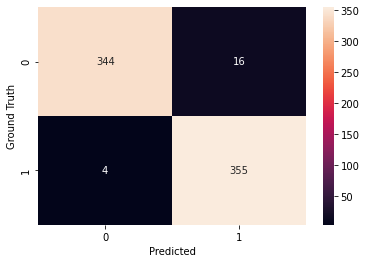

In [ ]:
import seaborn as sns

sns.heatmap(confusion_matrix(label, preds), annot=True, fmt='g')
plt.ylabel("Ground Truth")
plt.xlabel("Predicted")
plt.show()

### Voting Based Evaluation

In [ ]:
SAMPLE_RATE = 16000
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=501,
        n_mels=64)

ANNOTATIONS_FILE = "/content/drive/MyDrive/slider_data/data_2secs/eval_sets/"+TEST_SET+".csv"
AUDIO_DIR = "/content/drive/MyDrive/slider_data/"+TEST_FOLDER
data = SoundDatasetBuilder(ANNOTATIONS_FILE, AUDIO_DIR, mel_spectrogram, SAMPLE_RATE)

data_loader = torch.utils.data.DataLoader(data,
                                          batch_size=5, 
                                          shuffle=False, num_workers=2,
                                          pin_memory=True)

print(f"There are {len(data)} samples in the dataset.")

There are 4050 samples in the dataset.


In [ ]:
import time

model.eval()

def infer_with_voting(model, data_loader, use_cuda=True):
  z_list, label_list, pred_list, times = [], [], [], []
  for batch_x, batch_y in tqdm(data_loader):

    if not (np.min(batch_y.numpy())==np.max(batch_y.numpy())):
      raise ValueError("Batch has mixed files!")

    batch_x = Variable(batch_x, requires_grad=False)
    if use_cuda:
      batch_x = batch_x.cuda()

    start = time.time()
    preds = model.predict(batch_x)

    # Get vote
    pred = np.bincount(preds.numpy()).argmax()
    label = batch_y.numpy()[0]
    
    label_list.append(label)
    pred_list.append(pred)
    end = time.time()
    times.append(end-start)

  mean_time = np.mean(np.array(times))
  return label_list, pred_list, mean_time

In [ ]:
labels, preds, mt = infer_with_voting(model, data_loader, use_cuda=False)

100%|██████████| 810/810 [06:42<00:00,  2.01it/s]


In [ ]:
print(mt)

0.0037969880633884007


In [ ]:
np.unique(np.array(labels), return_counts=True)

(array([0, 1]), array([405, 405]))

In [ ]:
np.unique(np.array(preds), return_counts=True)

(array([0, 1]), array([409, 401]))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels, preds, digits=5))

              precision    recall  f1-score   support

           0    0.98533   0.99506   0.99017       405
           1    0.99501   0.98519   0.99007       405

    accuracy                        0.99012       810
   macro avg    0.99017   0.99012   0.99012       810
weighted avg    0.99017   0.99012   0.99012       810



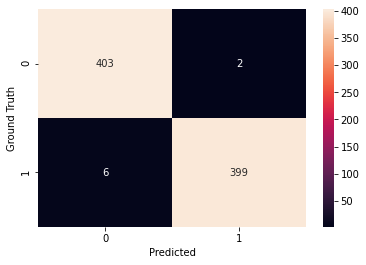

In [ ]:
import seaborn as sns

sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt='g')
plt.ylabel("Ground Truth")
plt.xlabel("Predicted")
plt.show()

In [ ]:
!nvidia-smi

Thu Sep  2 10:06:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    64W / 149W |   8477MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------